### setup

In [1]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import pickle
import warnings
warnings.filterwarnings("ignore")
import matplotlib
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
from matplotlib import gridspec
plt.ion()

#import pandas as pd
import geomdl

from datetime import datetime
from coastsat import SDS_download, SDS_preprocess, SDS_shoreline, SDS_tools, SDS_transects,SDS_universal_transects,SDS_upsampling



In [2]:
# area of interest (longitude, latitude in WGS84), can be loaded from a .kml polygon
polygon = SDS_tools.polygon_from_kml(os.path.join(os.getcwd(), 'example','dharavandhoo.kml'))
# date range
dates = ['2019-06-06', '2023-01-01']
# satellite missions
sat_list = ['S2']
# choose Landsat collection 'C01' or 'C02'
collection = 'C02'
# name of the site
sitename = 'dharavandhoo'
# directory where the data will be stored
filepath = os.path.join(os.getcwd(), 'data')
# put all the inputs into a dictionnary

inputs = {'polygon': polygon, 'dates': dates, 'sat_list': sat_list, 'sitename': sitename, 'filepath':filepath,
         'landsat_collection': collection}

# before downloading the images, check how many images are available for your inputs
SDS_download.check_images_available(inputs);

Number of images available between 2019-06-06 and 2023-01-01:
- In Landsat Tier 1 & Sentinel-2 Level-1C:
     S2: 201 images
  Total to download: 201 images


In [3]:
# get information about available images
metadata = SDS_download.get_metadata(inputs)

In [4]:
settings = {
    # general parameters:
    'cloud_thresh': 0.5,        # threshold on maximum cloud cover
    'dist_clouds': 300,         # ditance around clouds where shoreline can't be mapped
    'output_epsg': 28356,       # epsg code of spatial reference system desired for the output
    # quality control:
    'check_detection': False,    # if True, shows each shoreline detection to the user for validation
    'adjust_detection': False,  # if True, allows user to adjust the postion of each shoreline by changing the threhold
    'save_figure': True,        # if True, saves a figure showing the mapped shoreline for each image
    # [ONLY FOR ADVANCED USERS] shoreline detection parameters:
    'min_beach_area': 1000,     # minimum area (in metres^2) for an object to be labelled as a beach
    'min_length_sl': 500,       # minimum length (in metres) of shoreline perimeter to be valid
    'cloud_mask_issue': False,  # switch this parameter to True if sand pixels are masked (in black) on many images  
    'sand_color': 'bright',    # 'default', 'latest', 'dark' (for grey/black sand beaches) or 'bright' (for white sand beaches)
    'pan_off': False,           # True to switch pansharpening off for Landsat 7/8/9 imagery
    's2cloudless_prob': 60,     # probability threshold to identify cloudy pixels in the s2cloudless mask
    
    # add the inputs defined previously
    'inputs': inputs,
}

### Define reference shoreline

to ensure reference planes are generated in the proper orientation, define the reference shoreline clockwise for closed shorelines or with the land to the right for open shorelines.

In [5]:
%matplotlib qt
settings['reference_shoreline'] = SDS_preprocess.get_reference_sl(metadata, settings)
settings['max_dist_ref'] = 100 # max distance (in meters) allowed from the reference shoreline

Reference shoreline already exists and was loaded
Reference shoreline coordinates are in epsg:28356


### fit nurbs through shoreline to compute relative distances

In [6]:
#if periodic, set the last point equal to the first point
settings['periodic'] = True
# fit a nurbs curve through the shoreline
settings['reference_nurbs'] = SDS_universal_transects.fit_nurbs(settings['reference_shoreline'],degree=3,size=24,periodic=settings['periodic'])

### Batch shoreline detection
Extracts the 2D shorelines from the images in the spatial reference system specified by the user in `settings['output_epsg']`. The mapped shorelines are saved into `output.pkl` (under *./data/sitename*) and can also be saved as a `geojson` to be used in a GIS software (see below).

If you see that the sand pixels on the images are not being identified, change the parameter `sand_color` from `default` to `dark` or `bright` depending on the color of your beach. There is also another classifier called `latest` which contains all the training data. These different classifiers only apply to Landsat imagery, for Sentinel-2 there is only one. A new classifier can also be trained as shown in this [example](https://github.com/kvos/CoastSat/blob/master/classification/train_new_classifier.ipynb).

In [7]:
%matplotlib qt
output = SDS_shoreline.extract_shorelines(metadata, settings)

Mapping shorelines:
S2:   100%


Then remove duplicates and images with inaccurate georeferencing (threhsold at 10m)

In [8]:
output = SDS_tools.remove_duplicates(output) # removes duplicates (images taken on the same date by the same satellite)
output = SDS_tools.remove_inaccurate_georef(output, 10) # remove inaccurate georeferencing (set threshold to 10 m)

1 duplicates
0 bad georef


**If you have already mapped the shorelines**, just load the output file (`output.pkl`) by running the section below

In [9]:
filepath = os.path.join(inputs['filepath'], sitename)
with open(os.path.join(filepath, sitename + '_output' + '.pkl'), 'rb') as f:
    output = pickle.load(f)
# remove duplicates (images taken on the same date by the same satellite)
output = SDS_tools.remove_duplicates(output)
# remove inaccurate georeferencing (set threshold to 10 m)
output = SDS_tools.remove_inaccurate_georef(output, 10)

1 duplicates
0 bad georef


In [10]:
print(len(output['dates']))
output = SDS_universal_transects.remove_gaps(output,100)
print(len(output['dates']))

181
71 shorelines with gaps removed
110


Simple plot of the mapped shorelines. The coordinates are stored in the output dictionary together with the exact dates in UTC time, the georeferencing accuracy and the cloud cover.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


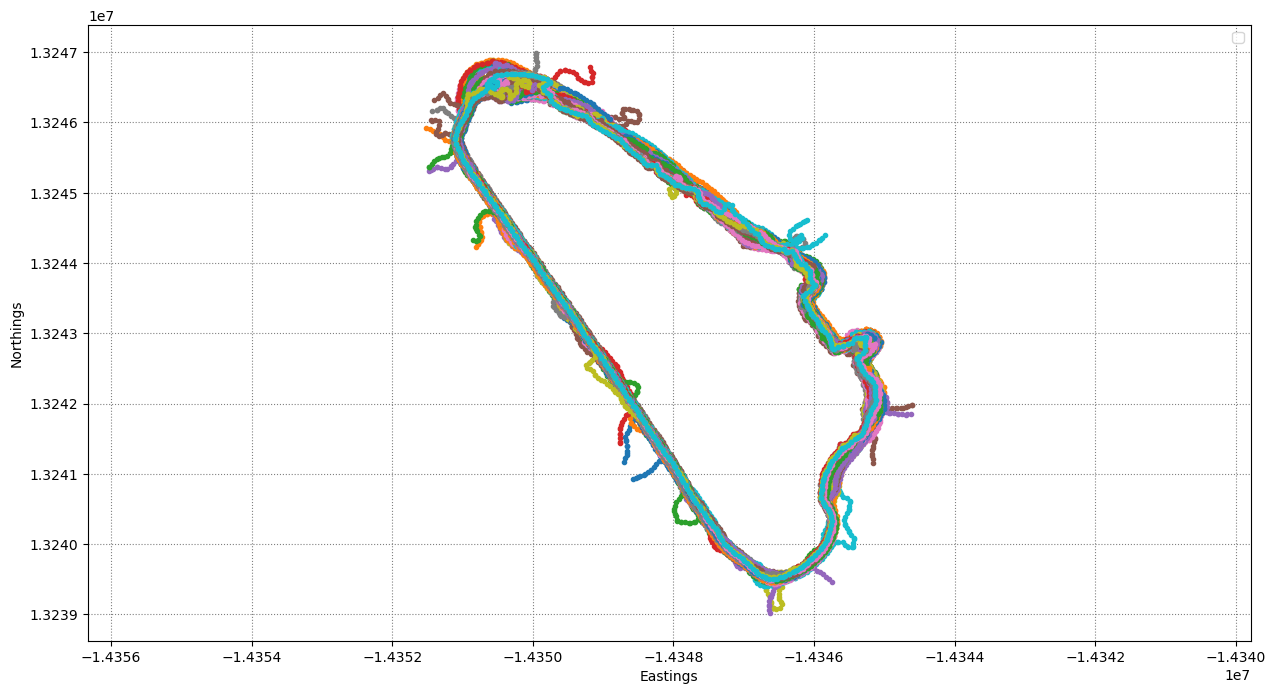

In [11]:
%matplotlib inline
fig = plt.figure(figsize=[15,8])
plt.axis('equal')
plt.xlabel('Eastings')
plt.ylabel('Northings')
plt.grid(linestyle=':', color='0.5')
for i in range(len(output['shorelines'])):
    sl = output['shorelines'][i]
    date = output['dates'][i]
    plt.plot(sl[:,0], sl[:,1], '.')#, label=date.strftime('%d-%m-%Y'))
plt.legend();
plt.show()

In [12]:
#set the reference nubrbs curve
ref_crv = settings['reference_nurbs'] 
# Set evaluation delta
settings['delta'] = 0.01
# generate the normals
curve_points,normals = SDS_universal_transects.get_normal_vector_along_nurbs(ref_crv, settings['delta'])


#create the transects as a dict (matching coastsat standards)
transects = SDS_universal_transects.tangent_dict(curve_points,normals,100)

In [15]:
curve_points


[[-14347632.33864876, 13245096.81197125],
 [-14347430.832746858, 13244996.109217111],
 [-14347302.817784272, 13244843.825669328],
 [-14347209.36824653, 13244668.376615146],
 [-14347111.558619127, 13244498.177341793],
 [-14346970.957680304, 13244361.315940576],
 [-14346776.935067091, 13244267.47778745],
 [-14346560.91675412, 13244198.50916127],
 [-14346357.828145312, 13244133.939901615],
 [-14346202.594644587, 13244053.29984805],
 [-14346126.393008107, 13243937.982048055],
 [-14346118.803188339, 13243790.054602688],
 [-14346143.480249332, 13243624.471181378],
 [-14346163.686349843, 13243456.38074107],
 [-14346142.683648646, 13243300.932238724],
 [-14346053.83281161, 13243170.223909304],
 [-14345912.156135561, 13243063.768161722],
 [-14345743.418107284, 13242977.832228648],
 [-14345573.383224959, 13242908.683339326],
 [-14345427.703878773, 13242852.55667411],
 [-14345321.066094724, 13242802.552402563],
 [-14345248.129257025, 13242746.045575408],
 [-14345201.419890866, 13242669.801512012]

In [14]:
#export the initial nurbs curve as a list of points
SDS_universal_transects.save_points_to_csv(curve_points,"data\initial_coast.csv")

True

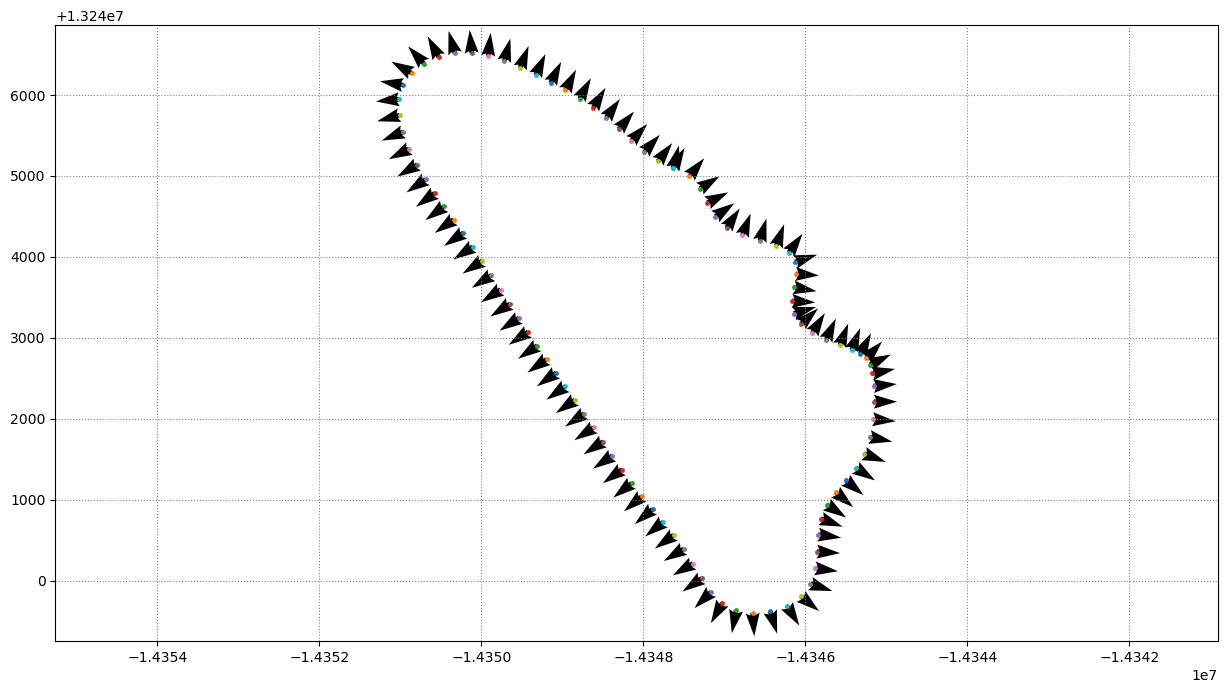

In [13]:
%matplotlib inline
fig = plt.figure(figsize=[15,8])
plt.axis('equal')
plt.grid(linestyle=':', color='0.5')


# plt.plot(tan[0], tan[1], '.',ms=5)
for i in range(len(curve_points)):
    plt.plot(curve_points[i][0], curve_points[i][1], '.',ms=5)
    plt.quiver(curve_points[i][0], curve_points[i][1], normals[i][0], normals[i][1], scale=50)
    
plt.show()

In [14]:
#testing finding the closest point on the curve and calculating distance
test_shoreline = output['shorelines'][0]
sample_point = test_shoreline[130]
pt,pt_t = SDS_universal_transects.closest_point_on_curve(ref_crv,0.005,sample_point)
ref_plane = SDS_universal_transects.get_plane_along_nurbs(ref_crv,pt_t)
pln_coords = SDS_universal_transects.get_plane_coordinates(sample_point,ref_plane)
#sample_point,ref_plane['origin'],pln_coords
print("distance="+pln_coords[1].__str__())


c_point,d = SDS_universal_transects.closest_point_in_plane_axis(test_shoreline,ref_plane,xweight=100)

distance=2.464727741030657


-7.934308300132615


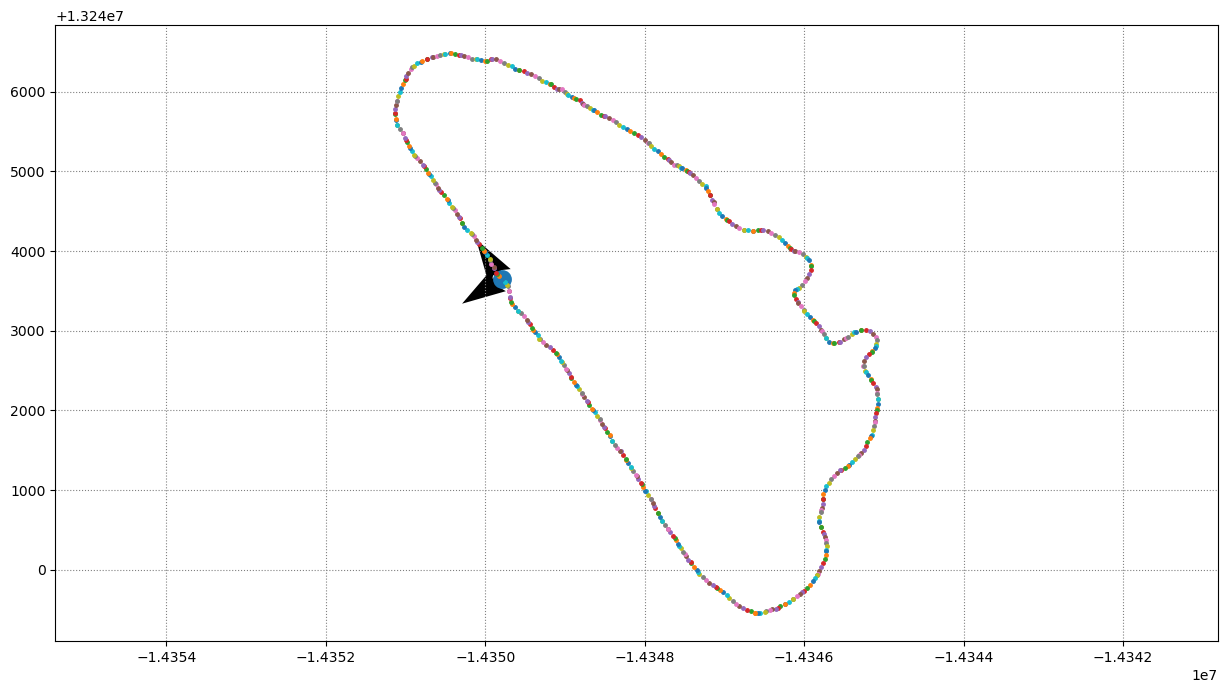

In [15]:
%matplotlib inline
fig = plt.figure(figsize=[15,8])
plt.axis('equal')
plt.grid(linestyle=':', color='0.5')
plt.quiver(ref_plane['origin'][0], ref_plane['origin'][1], ref_plane['xvec'][0], ref_plane['xvec'][1], scale=25)
plt.quiver(ref_plane['origin'][0], ref_plane['origin'][1], ref_plane['yvec'][0], ref_plane['yvec'][1], scale=25)

ref_pt,ref_distance = SDS_universal_transects.closest_point_in_plane_axis(test_shoreline,ref_plane)
print(ref_distance)
plt.plot(ref_pt[0],ref_pt[1], '.',ms=25)
# for i in range(len(curve_points)):
#     plt.plot(curve_points[i][0], curve_points[i][1], '.',ms=10)
for i in range(len(test_shoreline)):
    plt.plot(test_shoreline[i][0], test_shoreline[i][1], '.',ms=5)
    
plt.show()

In [41]:
transect_distance_csv_path = os.path.join(inputs['filepath'], 'offsets.csv')
settings["upd_reference_nurbs"],pts_out = SDS_universal_transects.record_shoreline_offsets(output,settings,transect_distance_csv_path)

calcualting 111 shorelines


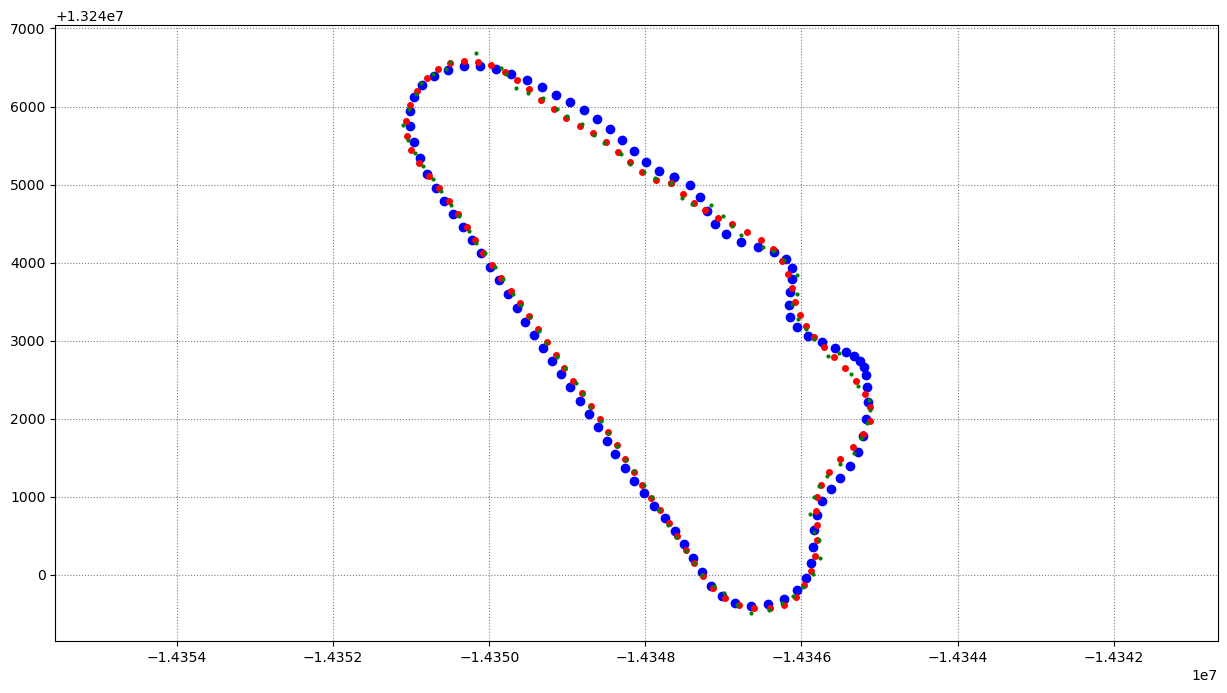

In [147]:
upt_crv = settings["upd_reference_nurbs"]

curve_points,normals = SDS_universal_transects.get_normal_vector_along_nurbs(ref_crv, settings['delta'])
upt_curve_points,upt_normals = SDS_universal_transects.get_normal_vector_along_nurbs(upt_crv, settings['delta'])

%matplotlib inline
fig = plt.figure(figsize=[15,8])
plt.axis('equal')
plt.grid(linestyle=':', color='0.5')
for i in range(len(curve_points)):
    plt.plot(curve_points[i][0], curve_points[i][1], '.',ms=12,color='blue')
for i in range(len(upt_curve_points)):
    plt.plot(upt_curve_points[i][0], upt_curve_points[i][1], '.',ms=8,color='red')
for i in range(len(pts_out)):
    plt.plot(pts_out[i][0], pts_out[i][1], '.',ms=4,color='green')
plt.show()

### infill missing days for export

In [75]:
#adding missing lines to csv export
SDS_universal_transects.infill_missing_days("D:\Github\CoastSat\data\offsets copy.csv")